
# SALSA — Inference + Visualization (TDS, 52 points)

This notebook runs **inference** with your trained backbone (**ViT** or **DINOv3-ConvNeXt**) and renders **52-point TDS** visualizations similar to the paper figure (Input | Ground truth | Prediction).  
It also **exports** predictions and targets to Excel.


In [9]:
import os
print(os.getcwd()) 

/mnt/sda/sijiali/GlaucomaCode


## Config

In [10]:
import os, json, math
from pathlib import Path
from typing import List, Optional

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch import nn
import timm

# Project utilities (must exist in your repo)
from dataset import HarvardGFDataset, SalsaHGFAlignedDataset
from utils import get_vit_transform, get_cnn_transform, get_albumentations_transform, get_imagenet_transform

# HF model for DINOv3
from transformers import AutoModel

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize

from dino_model import DinoV3Backbone52
from monai.metrics import RMSEMetric, MAEMetric


# ==== Config ====
# Paths
data_root = '/mnt/sda/sijiali/DataSet/harvardGF_unpacked'  
hgf_test_root = '/mnt/sda/sijiali/DataSet/Harvard-GF/Dataset/Test'
weight_path = '/mnt/sda/sijiali/GlaucomaCode/Results_SALSA/dinov3/dinov3_imagenet_cls_all_lr1e-4_novis/ckpts/best_model_epoch_306_rmse_0.8360.pth'
out_dir = f'./Results_visualization/SALSA/{weight_path.split("/")[-4]}/{weight_path.split("/")[-3]}'
pred_filename = 'test_pred.xlsx'
tar_filename  = 'test_tar.xlsx'

# Model
backbone = 'dinov3'  # 'vit' or 'dinov3'
hf_model_name = '/mnt/sda/sijiali/GlaucomaCode/pretrained_weight/dinov3-vitb16-pretrain-lvd1689m'  # used when backbone='dinov3'
vit_pool = 'cls'  # 'cls' or 'mean_patch'; used when backbone='dinov3'
device = 'cuda'

# Data / transforms
modality_type = 'rnflt'
task = 'tds'
resolution = 224
transform_name = 'imagenet'   # 'vit' | 'cnn' | 'albumentations' | 'none' | 'imagenet'

# Subset selection
mode = 'first_n'  # 'first_n' or 'ids'
n = 6             # only used when mode='first_n'
ids = ''          # comma-separated; used when mode='ids'
ids_file = ''     # a file with one id per line; used when mode='ids'

# Inference params
batch_size = 1
num_workers = 4
clamp = False

# Scale (IMPORTANT): if you trained with labels/10, keep scale=10.0 so we multiply predictions back.
scale = 10.0


## Functions

In [11]:

# ==== Helpers: list/pick ids ====
def list_all_ids(hgf_dir: str) -> List[str]:
    p = Path(hgf_dir)
    ids = sorted([f.name for f in p.iterdir() if f.is_dir()])
    if not ids:
        raise RuntimeError(f'No subdirectories found in {hgf_dir}')
    return ids

def pick_ids(hgf_dir: str, mode: str, n: int = 0, ids: Optional[List[str]] = None) -> List[str]:
    all_ids = list_all_ids(hgf_dir)
    if mode == 'first_n':
        assert n > 0, 'n must be > 0 for mode=first_n'
        return all_ids[:n]
    elif mode == 'ids':
        assert ids and len(ids) > 0, 'mode=ids requires ids'
        aset = set(all_ids)
        return [i for i in ids if i in aset]
    else:
        raise ValueError(f'Unknown mode: {mode}')


In [12]:

# ==== Build target DataFrame from .npz ====
def build_tar_df_from_npz(hgf_dir: str, picked_ids: List[str], lat_fill: str = 'Unknown') -> pd.DataFrame:
    vecs = []
    for sid in picked_ids:
        npz_path = os.path.join(hgf_dir, f'{sid}.npz')
        raw = np.load(npz_path, allow_pickle=True)
        if 'tds' not in raw.files:
            raise KeyError(f"'tds' not in {npz_path}, keys={raw.files}")
        vecs.append(raw['tds'].astype(np.float32))
    mat = np.stack(vecs, axis=0)  # (N,K)
    cols = [f'tar_{i}' for i in range(mat.shape[1])]
    df = pd.DataFrame(mat, columns=cols)
    df.insert(0, 'test_id', picked_ids)
    df.insert(1, 'test_lat', [lat_fill] * len(picked_ids))
    return df


In [13]:

# ==== Sequential sampler on specific indices ====
class SeqOnIndices(torch.utils.data.Sampler):
    def __init__(self, indices: List[int]):
        self.indices = indices
    def __iter__(self):
        return iter(self.indices)
    def __len__(self):
        return len(self.indices)

# ==== DataLoader subset ====
# def get_hgf_loader_subset(
#     hgf_dir: str,
#     modality_type: str,
#     task: str,
#     resolution: int,
#     depth: int,
#     transform,
#     picked_ids: List[str],
#     batch_size: int = 1,
#     num_workers: int = 4,
# ) -> DataLoader:
#     ds = HarvardGFDataset(
#         data_path=hgf_dir,
#         modality_type=modality_type,
#         task=task,
#         resolution=resolution,
#         depth=depth,
#         transform=transform,
#     )
#     id2idx = {Path(f).stem: i for i, f in enumerate(ds.files)}
#     indices = [id2idx[s] for s in picked_ids if s in id2idx]
#     sampler = SeqOnIndices(indices)
#     return DataLoader(
#         ds,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=num_workers,
#         sampler=sampler,
#         pin_memory=True,
#     )

def get_salsa_loader_subset(
    image_root: str,
    hgf_test_root: str,
    modality_type: str,
    transform,
    picked_ids: List[str],
    batch_size: int = 1,
    num_workers: int = 4,
) -> DataLoader:
    ds = SalsaHGFAlignedDataset(
        image_root=image_root,
        hgf_test_root=hgf_test_root,
        modality_type=modality_type,
        transform=transform
    )

    id2idx = {sid: i for i, sid in enumerate(ds.sample_ids)}
    indices = [id2idx[sid] for sid in picked_ids if sid in id2idx]

    sampler = SeqOnIndices(indices)
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        sampler=sampler,
        pin_memory=True,
    )


In [14]:

# ==== 52-point layout & visualization ====
HARVARD_GF_52_LAYOUT = [
    [None,  0,  1,  2,  3,  4,  5, None],
    [  6,   7,  8,  9, 10, 11, 12, 13],
    [ 14,  15, 16, 17, 18, 19, 20, 21],
    [ 22,  23, 24, 25, 26, 27, 28, 29],
    [ 30,  31, 32, 33, 34, 35, 36, 37],
    [ 38,  39, 40, 41, 42, 43, 44, 45],
    [None, 46, 47, 48, 49, 50, 51, None],
]

def _draw_vf(ax, values, layout=HARVARD_GF_52_LAYOUT, vmin=None, vmax=None,
             cmap='gray', fontsize=8, fmt='{:.1f}'):
    values = np.asarray(values).reshape(-1)
    assert values.size == 52, f'Expect 52 values, got {values.size}'
    if vmin is None: vmin = float(np.nanmin(values))
    if vmax is None: vmax = float(np.nanmax(values))
    norm = Normalize(vmin=vmin, vmax=vmax)
    ax.set_aspect('equal'); ax.axis('off')
    n_rows, n_cols = len(layout), len(layout[0])
    for r in range(n_rows):
        for c in range(n_cols):
            idx = layout[r][c]
            if idx is None: continue
            v = float(values[idx])
            rect = Rectangle((c, r), 1, 1, facecolor=plt.get_cmap(cmap)(norm(v)),
                             edgecolor='k', linewidth=0.5)
            ax.add_patch(rect)
            lum = norm(v)
            txt_color = 'white' if lum < 0.4 else 'black'
            ax.text(c+0.5, r+0.5, fmt.format(v), ha='center', va='center',
                    fontsize=fontsize, color=txt_color)
    ax.set_xlim(0, n_cols); ax.set_ylim(n_rows, 0)

def plot_vf_triptych(input_img, gt_52, pred_52, layout=HARVARD_GF_52_LAYOUT,
                     vmin=None, vmax=None, save_path=None, titles=('Input','Ground truth','Prediction')):
    gt_52  = np.asarray(gt_52).reshape(-1)
    pred_52 = np.asarray(pred_52).reshape(-1)
    if vmin is None: vmin = float(np.nanmin([gt_52.min(), pred_52.min()]))
    if vmax is None: vmax = float(np.nanmax([gt_52.max(), pred_52.max()]))
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), gridspec_kw={'width_ratios':[1.2,1,1]})
    # Input
    ax0 = axes[0]; ax0.axis('off'); ax0.set_title(titles[0])

    img = input_img
    # 1) 转 numpy
    if torch.is_tensor(img):
        img = img.detach().cpu()
        # 如果是 (C,H,W) 且 C=1/3，先转 (H,W,C)
        if img.ndim == 3 and img.shape[0] in (1,3):
            img = img.permute(1, 2, 0)
        img = img.numpy()

    # 2) 处理通道数
    if img.ndim == 2:
        # (H,W) 灰度 -> 扩成 3 通道
        img = np.repeat(img[..., None], 3, axis=2)
    elif img.ndim == 3 and img.shape[2] == 1:
        # (H,W,1) -> (H,W,3)
        img = np.repeat(img, 3, axis=2)

    # 3) 数值范围（如果是 float 且不是 uint8，clip 到 [0,1]）
    if img.dtype != np.uint8:
        img = np.clip(img, 0.0, 1.0)

    ax0.imshow(img)
    # GT & Pred
    axes[1].set_title(titles[1]); _draw_vf(axes[1], gt_52, layout, vmin, vmax)
    axes[2].set_title(titles[2]); _draw_vf(axes[2], pred_52, layout, vmin, vmax)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=200); plt.close(fig)
    else: plt.show()

def preview_layout(layout=HARVARD_GF_52_LAYOUT):
    dummy = np.arange(52)
    fig, ax = plt.subplots(figsize=(4,4))
    _draw_vf(ax, dummy, layout, vmin=0, vmax=51, fmt='{:.0f}')
    ax.set_title('Index layout (0..51)'); plt.tight_layout(); plt.show()


## Infer

In [15]:
# 放到文件顶部
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm_imagenet_tensor(img: torch.Tensor) -> torch.Tensor:
    """
    img: (C,H,W)，经过 Normalize(mean,std) 的张量
    返回: 反标准化到 [0,1] 区间的张量（仍是 (C,H,W)）
    """
    mean = IMAGENET_MEAN.to(img.device)
    std  = IMAGENET_STD.to(img.device)
    x = img * std + mean
    return x.clamp(0.0, 1.0)

def tensor_CHW_to_uint8_HWC(img: torch.Tensor) -> np.ndarray:
    """
    将 [0,1] 的 (C,H,W) 张量转成 uint8 的 (H,W,C)（可直接用 cv2/PIL 显示）
    """
    x = img.detach().cpu().clamp(0,1)
    x = (x.permute(1,2,0).numpy() * 255.0).round().astype(np.uint8)
    return x


In [16]:

# ==== Build model, DataLoader, run inference, export ====
# 1) Pick IDs
if mode == 'first_n':
    picked_ids = pick_ids(data_root, 'first_n', n=n)
else:
    id_list = []
    if ids:      id_list += [s.strip() for s in ids.split(',') if s.strip()]
    if ids_file:
        with open(ids_file, 'r') as f:
            id_list += [line.strip() for line in f if line.strip()]
    picked_ids = pick_ids(data_root, 'ids', ids=id_list)
print(f'[SALSA] picked {len(picked_ids)} samples.')

# 2) Transform
mean = np.array([0.485, 0.456, 0.406]); std = np.array([0.229, 0.224, 0.225])
if transform_name == 'vit':
    transform = get_vit_transform(resolution)
elif transform_name == 'cnn':
    transform = get_cnn_transform(resolution, mean, std)
elif transform_name == 'albumentations':
    transform = get_albumentations_transform(resolution)
elif transform_name == 'none':
    transform = None
elif transform_name == 'imagenet':
    transform = get_imagenet_transform(resolution)
else:
    raise ValueError(f'Unknown transform: {transform_name}')

# 3) DataLoader
test_loader = get_salsa_loader_subset(
    image_root=data_root,
    hgf_test_root=hgf_test_root,
    modality_type=modality_type,
    transform=transform,
    picked_ids=picked_ids,
    batch_size=batch_size,
    num_workers=num_workers,
)

all_test_id  = picked_ids
all_test_lat = ['Unknown'] * len(picked_ids)

# 4) Model
num_classes = 52
if backbone == 'vit':
    model = timm.create_model(
        'vit_base_patch8_224.augreg2_in21k_ft_in1k',
        pretrained=False,
        pretrained_cfg_overlay=dict(file='/mnt/sda/sijiali/GlaucomaCode/vit_base_patch8_224.augreg2_in1k_ft_in1k/pytorch_model.bin')
    )
    dim = model.head.in_features
    model.head = nn.Sequential(nn.ReLU(), nn.Linear(dim, num_classes))
elif backbone == 'dinov3':
    model = DinoV3Backbone52(hf_model_name=hf_model_name, out_dim=num_classes,
                             apply_imagenet_norm=False, vit_pool=vit_pool)
else:
    raise ValueError(f'Unknown backbone: {backbone}')

# 5) Load weights (handle DataParallel prefix)
def _strip_module_prefix(state_dict):
    if any(k.startswith('module.') for k in state_dict.keys()):
        return {k.replace('module.', '', 1): v for k, v in state_dict.items()}
    return state_dict

ckpt = torch.load(weight_path, map_location='cpu')
state = ckpt.get('model_state', ckpt)
state = _strip_module_prefix(state)
missing, unexpected = model.load_state_dict(state, strict=False)
print('[load] missing:', missing, '| unexpected:', unexpected)

# 6) Inference loop (per-sample + overall metrics)
model.eval(); model.to(device)
pred_rows = []
imgs_cache = []   # keep a few images for visualization

# （可选）整体聚合
rmse_metric = RMSEMetric()
mae_metric  = MAEMetric()

idx = 0  # 全局样本索引（与 picked_ids 对齐）
with torch.no_grad():
    for batch in test_loader:
        x = batch['image'].to(device)
        y = batch.get('label', None)

        # 前向
        out_scaled = model(x)          # [B, 52]
        out = out_scaled * scale       # 还原到原始单位

        # 整体聚合
        if y is not None:
            rmse_metric(out, y.to(device))
            mae_metric(out, y.to(device))

        # 逐样本处理
        out_np = out.detach().cpu().numpy()
        B = out_np.shape[0]

        for b in range(B):
            sid = all_test_id[idx]
            row = {'test_id': sid, 'test_lat': all_test_lat[idx]}

            # 保存预测值
            for k in range(52):
                row[f'pred_{k}'] = float(out_np[b, k])

            # 逐样本 MAE/RMSE
            if y is not None:
                gt_b = y[b].cpu().numpy()
                diff = out_np[b] - gt_b
                mae  = float(np.mean(np.abs(diff)))
                rmse = float(np.sqrt(np.mean(diff ** 2)))
            else:
                mae, rmse = float('nan'), float('nan')

            row['mae']  = mae
            row['rmse'] = rmse
            pred_rows.append(row)

            # 打印每个样本的结果
            print(f"[Sample {idx}] id={sid}, MAE={mae:.4f}, RMSE={rmse:.4f}")

            # 缓存少量样本做可视化
            if idx < 12:
                img_norm = batch['image'][b]
                img_denorm = denorm_imagenet_tensor(img_norm)
                gt_arr = (y[b].cpu().numpy() if y is not None else np.full(52, np.nan))
                imgs_cache.append((sid, img_denorm, gt_arr, out_np[b]))

            idx += 1

# （可选）整体平均指标
try:
    overall_rmse = rmse_metric.aggregate().item()
    overall_mae  = mae_metric.aggregate().item()
    print(f"[VAL] Overall RMSE: {overall_rmse:.4f}, Overall MAE: {overall_mae:.4f}")
except Exception:
    pass



pred_df = pd.DataFrame(pred_rows)
# print(pred_df.head())

# 7) Export predictions & targets
Path(out_dir).mkdir(parents=True, exist_ok=True)
pred_xlsx = os.path.join(out_dir, pred_filename)
pred_df.to_excel(pred_xlsx, index=False)
print(f'[SAVE] predictions -> {pred_xlsx}')

tar_df = build_tar_df_from_npz(hgf_test_root, all_test_id, lat_fill='Unknown')
tar_xlsx = os.path.join(out_dir, tar_filename)
tar_df.to_excel(tar_xlsx, index=False)
print(f'[SAVE] targets -> {tar_xlsx}')


[SALSA] picked 6 samples.
[load] missing: [] | unexpected: []
[Sample 0] id=data_2401, MAE=0.0341, RMSE=0.0444
[Sample 1] id=data_2402, MAE=0.0266, RMSE=0.0322
[Sample 2] id=data_2403, MAE=3.3950, RMSE=3.8945
[Sample 3] id=data_2404, MAE=0.0521, RMSE=0.0635
[Sample 4] id=data_2405, MAE=0.0360, RMSE=0.0449
[Sample 5] id=data_2406, MAE=5.4481, RMSE=6.7215
[VAL] Overall RMSE: 1.8002, Overall MAE: 1.4986
[SAVE] predictions -> ./Results_visualization/SALSA/dinov3/dinov3_imagenet_cls_all_lr1e-4_novis/test_pred.xlsx
[SAVE] targets -> ./Results_visualization/SALSA/dinov3/dinov3_imagenet_cls_all_lr1e-4_novis/test_tar.xlsx


## Visualization

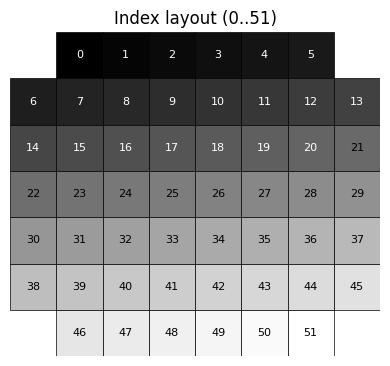

In [17]:

# ==== Visualization: layout preview ====
preview_layout(HARVARD_GF_52_LAYOUT)


In [18]:

# ==== Visualization: a few examples ====
# vmin/vmax you can fix, e.g., vmin=-30, vmax=5 for TDS-like ranges.
vmin, vmax = None, None  # or set to (-30, 5)

save_pngs = True
save_dir = os.path.join(out_dir, 'figs')
Path(save_dir).mkdir(parents=True, exist_ok=True)

for sid, img, gt, pred_scaled in imgs_cache:
    pred = pred_scaled * 1.0   # already scaled back earlier (out = out_scaled*scale)
    save_path = os.path.join(save_dir, f'{sid}.png') if save_pngs else None
    plot_vf_triptych(
        input_img=img, 
        gt_52=gt, 
        pred_52=pred, 
        vmin=vmin, vmax=vmax, 
        save_path=save_path
    )
    if not save_pngs:
        break  # if not saving, display only the first one
print(f'[SAVE] figures -> {save_dir}')


[SAVE] figures -> ./Results_visualization/SALSA/dinov3/dinov3_imagenet_cls_all_lr1e-4_novis/figs
